https://arxiv.org/pdf/1712.04609.pdf

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import random
import matplotlib.pyplot as plt

import bspline
import bspline.splinelab as splinelab

import warnings
warnings.filterwarnings("ignore")

Рассмотрим европейский пут опцион  
$$C_t^{\left(BS\right)}=Ke^{-r\left(T-t\right)}\mathcal N\left(-d_2\right)-S_t\mathcal N\left(-d_1\right)$$

In [2]:
# ф-лы БШ
def bs_put(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = K * np.exp(-r * (T-t)) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    return price

def bs_call(t, S0, K, r, sigma, T):
    d1 = (np.log(S0/K) + (r + 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    d2 = (np.log(S0/K) + (r - 1/2 * sigma**2) * (T-t)) / sigma / np.sqrt(T-t)
    price = S0 * norm.cdf(d1) - K * np.exp(-r * (T-t)) * norm.cdf(d2)
    return price

### MC параметры

Данные из
https://arxiv.org/pdf/1801.06077.pdf (с.11)

In [3]:
S0 = 100      
mu = 0.05     # дрифт
sigma = 0.15 
r = 0.03    
M = 1         # срок погашения
T = 24        # число временных отрезков

N_MC = 10_000 # кол-во путей

delta_t = M / T                # временной интервал
gamma = np.exp(-r * delta_t)  # коэф. дисконтирования

### БШ симуляция

Смоделируем $N_{MC}$ траекторий движения цены акций с шагом $T$ по классической формуле Блэка-Шоулза.

$$dS_t=\mu S_tdt+\sigma S_tdW_t\quad\quad S_{t+1}=S_te^{\left(\mu-\frac{1}{2}\sigma^2\right)\Delta t+\sigma\sqrt{\Delta t}Z}$$

На основе смоделированных путей цен акций $S_t$ вычислим переменную состояния $X_t$ по следующему соотношению.

$$X_t=-\left(\mu-\frac{1}{2}\sigma^2\right)t\Delta t+\log S_t$$

Также вычислим

$$\Delta S_t=S_{t+1}-e^{r\Delta t}S_t\quad\quad \Delta\hat{S}_t=\Delta S_t-\Delta\bar{S}_t\quad\quad t=0,...,T-1$$

где $\Delta\bar{S}_t$ выборочное среднее всех значений $\Delta S_t$.

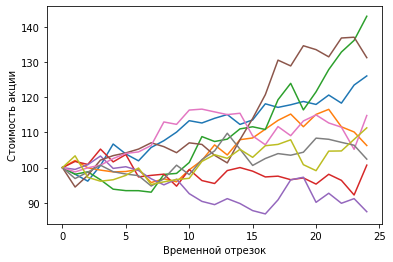

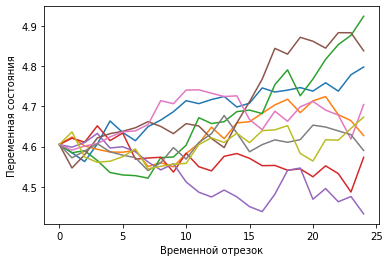

In [4]:
# создадим датасет 

np.random.seed(42) 
# цена акции
S = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
S.loc[:,0] = S0

# ст. нормально распределенные случайные величины
RN = pd.DataFrame(np.random.randn(N_MC,T), index=range(1, N_MC+1), columns=range(1, T+1))

for t in range(1, T+1):
    S.loc[:,t] = S.loc[:,t-1] * np.exp((mu - 1/2 * sigma**2) * delta_t + sigma * np.sqrt(delta_t) * RN.loc[:,t])

delta_S = S.loc[:,1:T].values - np.exp(r * delta_t) * S.loc[:,0:T-1]
delta_S_hat = delta_S.apply(lambda x: x - np.mean(x), axis=0)

# переменная состояния
X = - (mu - 1/2 * sigma**2) * np.arange(T+1) * delta_t + np.log(S)   # delta_t here is due to their conventions

# графики
step_size = N_MC // 10
idx_plot = np.arange(step_size, N_MC, step_size)
plt.plot(S.T.iloc[:, idx_plot])
plt.xlabel('Временной отрезок')
plt.ylabel('Стоимость акции')
plt.show()

plt.plot(X.T.iloc[:, idx_plot])
plt.xlabel('Временной отрезок')
plt.ylabel('Переменная состояния')
plt.show()

In [5]:
def terminal_payoff(ST, K):
    return max(K-ST, 0)

X.shape =  (10000, 25)
X_min, X_max =  4.024923524903037 5.190802775129617
Number of points k =  17


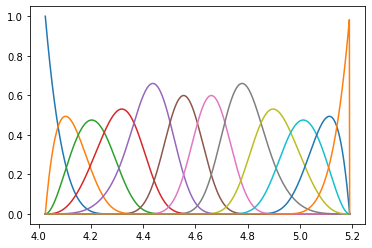

In [6]:
X_min = np.min(np.min(X))
X_max = np.max(np.max(X))

p = 4              # 4: B-spline
ncolloc = 12
tau = np.linspace(X_min,X_max,ncolloc)  
k = splinelab.aptknt(tau, p) 
basis = bspline.Bspline(k, p)        
f = plt.figure()

print('X.shape = ', X.shape)
print('X_min, X_max = ', X_min, X_max)
print('Number of points k = ', len(k))
basis.plot()

In [7]:
%%time
num_t_steps = T + 1
num_basis =  ncolloc  

data_mat_t = np.zeros((num_t_steps, N_MC, num_basis ))
for i in np.arange(num_t_steps):
    x = X.values[:,i]
    data_mat_t[i,:,:] = np.array([ basis(el) for el in x ])

print('num_basis = ', num_basis)

num_basis =  12
Wall time: 26.5 s


## Подход ДП для QLBS 

Задача МППР (MDP) в этом случае состоит в том, чтобы решить следующее уравнение оптимальности Беллмана для функции действия-ценности (Q).

$$Q_t^\star\left(x,a\right)=\mathbb{E}_t\left[R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\space|\space X_t=x,a_t=a\right],\space\space t=0,...,T-1,\quad\gamma=e^{-r\Delta t}$$

$$R_t\left(X_t,a_t,X_{t+1}\right)$$ - зависящее от времени случайное вознаграждение  
$$a_t\left(X_t\right)$$ - действие (хеджирование)  
стр. 16 - 17

In [8]:
risk_lambda = 0.001 
K = 100 

$$A_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)\left(\Delta\hat{S}_t^k\right)^2}\quad\quad$$          

$$B_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left[\hat\Pi_{t+1}^k\Delta\hat{S}_t^k+\frac{1}{2\gamma\lambda}\Delta S_t^k\right]}$$

In [9]:
# стр. 16, ур. - (46)
def function_A(t, delta_S_hat, data_mat, reg_param):
    X_mat = data_mat[t, :, :]
    num_basis_func = X_mat.shape[1] 
    dS = delta_S_hat.loc[:, t].values
    hat_dS2 = (dS ** 2).reshape(-1, 1)
    A_mat = np.dot(X_mat.T, X_mat * hat_dS2) + reg_param * np.eye(num_basis_func)    
    return A_mat


def function_B(t, Pi_hat, delta_S_hat = delta_S_hat, S = S,
                   data_mat = data_mat_t, gamma = gamma, risk_lambda = risk_lambda):
    coef = 0
    tmp = Pi_hat.loc[:,t+1] * delta_S_hat.loc[:, t] + coef * (np.exp(mu*delta_t) - np.exp(r*delta_t))* S.loc[:,t]
    X_mat = data_mat[t, :, :] 
    B_vec = np.dot(X_mat.T, tmp)  
    return B_vec

Посчитаем оптимальное действие $a_t^\star\left(X_t\right)=\sum_n^N{\phi_{nt}\Phi_n\left(X_t\right)}$ обратной рекурсией с терминальным условием $a_T^\star\left(X_T\right)=0$  
Также найдем стоимость портфеля  
$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$  
$\Pi_T=H_T\left(S_T\right)=\max\left(K-S_T,0\right)$

In [10]:
# стоимость портфеля
Pi = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_hat.iloc[:,-1] = Pi.iloc[:,-1] - np.mean(Pi.iloc[:,-1])

# оптимальное действие
a = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a.iloc[:,-1] = 0

reg_param = 1e-3
for t in range(T-1, -1, -1):
    A_mat = function_A(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B(t, Pi_hat, delta_S_hat, S, data_mat_t)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    a.loc[:,t] = np.dot(data_mat_t[t,:,:],phi)
    Pi.loc[:,t] = gamma * (Pi.loc[:,t+1] - a.loc[:,t] * delta_S.loc[:,t])
    Pi_hat.loc[:,t] = Pi.loc[:,t] - np.mean(Pi.loc[:,t])

a = a.astype('float')
Pi = Pi.astype('float')
Pi_hat = Pi_hat.astype('float')

Найдем  
$Q_t^\star\left(X_t,a_t^\star\right)=\sum_n^N{\omega_{nt}\Phi_n\left(X_t\right)}$,  
где $\omega_t=\mathbf C_t^{-1}\mathbf D_t$

Коэффициенты C и D заданы ур. 50, стр.17

$$C_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\Phi_m\left(X_t^k\right)}\quad\quad$$ $$D_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Phi_n\left(X_t^k\right)\left(R_t\left(X_t,a_t^\star,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

In [11]:
def function_C(t, data_mat, reg_param):
    X_mat = data_mat[t,:,:]
    num_basis_func = X_mat.shape[1]
    C_mat  = np.dot(X_mat.T,X_mat) + reg_param * np.eye(num_basis_func) 
    return C_mat

def function_D(t, Q, R, data_mat, gamma=gamma):
    X_mat = data_mat[t, :, :]
    D_vec = np.dot(X_mat.T, R.loc[:,t] + gamma * Q.loc[:, t+1])
    return D_vec

Найдем награждения по формуле (31), стр.13
$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=0,...,T-1$  
$R_T=-\lambda Var\left[\Pi_T\right]$

In [12]:
# функция награждений 
R = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R.iloc[:,-1] = - risk_lambda * np.var(Pi.iloc[:,-1])
for t in range(T):
    R.loc[1:,t] = gamma * a.loc[1:,t] * delta_S.loc[1:,t] - risk_lambda * np.var(Pi.loc[1:,t])

In [13]:
# Q функция
Q = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

reg_param = 1e-3
for t in range(T-1, -1, -1):
    C_mat = function_C(t,data_mat_t,reg_param)
    D_vec = function_D(t, Q,R,data_mat_t,gamma)
    omega = np.dot(np.linalg.inv(C_mat), D_vec)
    
    Q.loc[:,t] = np.dot(data_mat_t[t,:,:], omega)
    
Q = Q.astype('float')

In [14]:
C_QLBS = - Q.copy()
print('QLBS Put Price: ', C_QLBS.iloc[0,0])
print('BS Put Price:', bs_put(t=0, S0=S0, K=K, r=r, sigma=sigma, T=M))

QLBS Put Price:  4.926125420342084
BS Put Price: 4.529640948763429


In [15]:
dp_price = C_QLBS.iloc[0,0]

In [ ]:
====================================================================

### Fitted Q-learning

- считаем оптимальную стратегию и результат записываем в a_op
- добавляем случайный шум $$a_t\left(X_t\right) = a_t^\star\left(X_t\right) \sim U\left[1-\eta, 1 + \eta\right]$$
- вычисляем стоимость портфеля  $$\Pi_t=\gamma\left[\Pi_{t+1}-a_t^\star\Delta S_t\right]\quad t=T-1,...,0$$
- вычисляем награды
$$R_t\left(X_t,a_t,X_{t+1}\right)=\gamma a_t\Delta S_t-\lambda Var\left[\Pi_t\space|\space\mathcal F_t\right]\quad t=T-1,...,0$$

In [16]:
eta = 0.5 
reg_param = 1e-3
np.random.seed(42)

# действия
a_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_op.iloc[:,-1] = 0

# портфель
Pi_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op.iloc[:,-1] = S.iloc[:,-1].apply(lambda x: terminal_payoff(x, K))

Pi_op_hat = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Pi_op_hat.iloc[:,-1] = Pi_op.iloc[:,-1] - np.mean(Pi_op.iloc[:,-1])

# награда
R_op = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
R_op.iloc[:,-1] = - risk_lambda * np.var(Pi_op.iloc[:,-1])

for t in range(T-1, -1, -1):        
    a_op.loc[:,t] = a.loc[:,t]
    a_op.loc[:, t] = a_op.loc[:, t] * np.random.uniform(1 - eta, 1 + eta, size=a_op.shape[0])    
    Pi_op.loc[:,t] = gamma * (Pi_op.loc[:,t+1] - a_op.loc[:,t] * delta_S.loc[:,t])
    Pi_op_hat.loc[:,t] = Pi_op.loc[:,t] - np.mean(Pi_op.loc[:,t])    
    R_op.loc[:,t] = gamma * a_op.loc[:,t] * delta_S.loc[:,t] - risk_lambda * np.var(Pi_op.loc[:,t])

In [17]:
a = a_op.copy()     
Pi = Pi_op.copy()    
Pi_hat = Pi_op_hat.copy()
R = R_op.copy()

In [18]:
# матрица A_t (3 x num_MC x num_steps)
num_MC = a.shape[0] # кол-во путей
num_TS = a.shape[1] # кол-во врем.шагов
a_1_1 = a.values.reshape((1, num_MC, num_TS))

a_1_2 = 0.5 * a_1_1 ** 2
ones_3d = np.ones((1, num_MC, num_TS))

A_stack = np.vstack((ones_3d, a_1_1, a_1_2))

#print(A_stack.shape)

In [19]:
data_mat_swap_idx = np.swapaxes(data_mat_t,0,2)
#print(data_mat_swap_idx.shape) # (12, 10000, 25)
A_2 = np.expand_dims(A_stack, axis=1)
data_mat_swap_idx = np.expand_dims(data_mat_swap_idx, axis=0) 
Psi_mat = np.multiply(A_2, data_mat_swap_idx) 
Psi_mat = Psi_mat.reshape(-1, N_MC, T+1, order='F') # (36, 10000, 25)

In [20]:
Psi_1_aux = np.expand_dims(Psi_mat, axis=1)
Psi_2_aux = np.expand_dims(Psi_mat, axis=0)
#print(Psi_1_aux.shape) # (36, 1, 10000, 25)
#print(Psi_2_aux.shape) # (1, 36, 10000, 25)
S_t_mat = np.sum(np.multiply(Psi_1_aux, Psi_2_aux), axis=2) # (36, 36, 25)

c.20-21; фор-лы 60-61  
$$\vec W_t=\mathbf S_t^{-1}\mathbf M_t$$
$$S_{nm}^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\Psi_m\left(X_t^k,a_t^k\right)}\quad\quad M_n^{\left(t\right)}=\sum_{k=1}^{N_{MC}}{\Psi_n\left(X_t^k,a_t^k\right)\left(R_t\left(X_t,a_t,X_{t+1}\right)+\gamma\max_{a_{t+1}\in\mathcal{A}}Q_{t+1}^\star\left(X_{t+1},a_{t+1}\right)\right)}$$

In [21]:
def function_S(t, S_t_mat, reg_param):   
    num_Qbasis = S_t_mat.shape[0]
    S_mat_reg = S_t_mat[:,:,t] + reg_param * np.eye(num_Qbasis)    
    return S_mat_reg
   
def function_M(t, Q_star, R, Psi_mat_t, gamma=gamma):
    M_t = np.dot(Psi_mat_t, R.loc[:,t] + gamma * Q_star.loc[:, t+1])
    return M_t

#### fitted Q iteration

Рассмотрим функцию $Q_t^\star\left(X_t,a_t\right)$ в следующем виде ф-ла (56) с. 21:
$Q_t^\star\left(X_t,a_t\right)=\mathbf A_t^T\mathbf U_W\left(t,X_t\right)$, где 
$$  \mathbf U_{W} \left(t,X_t \right) = 
\left[\begin{matrix} \mathbf U_W^{0,k}\left(t,X_t \right) \\  
\mathbf U_W^{1,k}\left(t,X_t \right) \\ \mathbf U_W^{2,k} \left(t,X_t \right)
\end{matrix}\right]
= \bf{W}_t \Phi_t \left(t,X_t \right)  $$

Чтобы найти оптимальную Q-функцию, используем ф-лу (62) c.22:  
$$Q_t^\star\left(X_t,a_t^\star\right)=\mathbf U_W^{\left(0\right)}\left(t,X_t\right)+ a_t^\star \mathbf U_W^{\left(1\right)}\left(t,X_t\right) +\frac{1}{2}\left(a_t^\star\right)^2\mathbf U_W^{\left(2\right)}\left(t,X_t\right)$$


In [22]:
%%time

# ф-ла 37, с.14 
# предполагаемая Q-функция по входным данным
Q_RL = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_RL.iloc[:,-1] = - Pi.iloc[:,-1] - risk_lambda * np.var(Pi.iloc[:,-1])

# оптимальное действие
a_opt = np.zeros((N_MC,T+1))
a_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
a_star.iloc[:,-1] = 0

# оптимальная Q-функция
Q_star = pd.DataFrame([], index=range(1, N_MC+1), columns=range(T+1))
Q_star.iloc[:,-1] = Q_RL.iloc[:,-1]

max_Q_star = np.zeros((N_MC,T+1))
max_Q_star[:,-1] = Q_RL.iloc[:,-1].values

num_basis = data_mat_t.shape[2]

reg_param = 1e-3
hyper_param =  1e-1

for t in range(T-1, -1, -1):
    # W_t
    S_mat_reg = function_S(t,S_t_mat,reg_param) 
    M_t = function_M(t,Q_star, R, Psi_mat[:,:,t], gamma)
    W_t = np.dot(np.linalg.inv(S_mat_reg), M_t)      
    W_mat = W_t.reshape((3, num_basis), order='F')  
        
    # матрица Ф_t
    Phi_mat = data_mat_t[t,:,:].T 

    # вычисляем U_mat
    U_mat = np.dot(W_mat, Phi_mat)
    U_W_0 = U_mat[0,:]
    U_W_1 = U_mat[1,:]
    U_W_2 = U_mat[2,:]

    A_mat = function_A(t, delta_S_hat, data_mat_t, reg_param)
    B_vec = function_B(t, Pi_hat, delta_S_hat, S, data_mat_t)
    phi = np.dot(np.linalg.inv(A_mat), B_vec)
    a_opt[:,t] = np.dot(data_mat_t[t,:,:],phi)
    a_star.loc[:,t] = a_opt[:,t] 
    max_Q_star[:,t] = U_W_0 + a_opt[:,t] * U_W_1 + 0.5 * (a_opt[:,t]**2) * U_W_2       
    
    # обновляем Q_star и Q_RL
    Q_star.loc[:,t] = max_Q_star[:,t]
    Psi_t = Psi_mat[:,:,t].T  
    Q_RL.loc[:,t] = np.dot(Psi_t, W_t)
    
    # убираем выбросы Q_RL
    up_percentile_Q_RL =  95 
    low_percentile_Q_RL = 5    
    low_perc_Q_RL, up_perc_Q_RL = np.percentile(Q_RL.loc[:,t],[low_percentile_Q_RL,up_percentile_Q_RL])
    
    # убираем выбросы max_Q_star:
    flag_lower = Q_RL.loc[:,t].values < low_perc_Q_RL
    flag_upper = Q_RL.loc[:,t].values > up_perc_Q_RL
    Q_RL.loc[flag_lower,t] = low_perc_Q_RL
    Q_RL.loc[flag_upper,t] = up_perc_Q_RL

Wall time: 200 ms


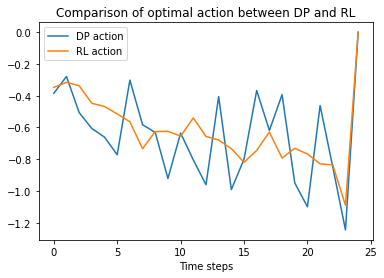

In [23]:
n_path =  200
plt.plot(a.T.iloc[:,n_path], label="DP action")
plt.plot(a_star.T.iloc[:,n_path], label="RL action")
plt.legend()
plt.xlabel('Time steps')
plt.title('Comparison of optimal action between DP and RL')
plt.show()

#### Results

In [25]:
C_QLBS = -Q_star.copy()

print('QLBS Put Price (DP):', dp_price)
print('QLBS Put Price (RL):', (np.mean(C_QLBS.iloc[:,0])))
print('BS Put Price:', bs_put(t=0, S0=S0, K=K, r=r, sigma=sigma, T=M))

QLBS Put Price (DP): 4.926125420342084
QLBS Put Price (RL): 5.103516435679476
BS Put Price: 4.529640948763429
